In [206]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
np.set_printoptions(threshold=np.inf)

In [431]:
# Constants
hbar = 1.0   # Planck's constant / 2π
m = .1
R = 32
U = 1
distance = (R)*5
earth_cutoff = R / distance

# Based on the condition given in equation 3, the eigenvalue k^2 << (m*U)^3/2 * R in order for there to be a large asymmetry
k_condition = (m*U)**(3/2) * R
print(k_condition)
print((m * 1E-14)**(3/2) * 3.2E13)

# delta negative is neutrino, delta positive is anti-neutrino

# scale earth down a lot to like a few meters, scale k down as well but like not as small compared to earth as it currently is
# base these values off equation 3
#make it very followed and very violated and see what happens as a toy model

# make sure that our largest eigenvalue has to be much greater than 10^-8 (which is k^2) because that allows us to just use the values
# that represent the CnuB IRL
# this can give us a sense of how many points/distance to use actually :)

#actual values:
# R = 3.2E13 1/ev
# U = 1E-14

1.0119288512538815
1.0119288512538816e-09


In [534]:
# define derivative matrices

def first_deriv(N, r):
    diags0 = np.zeros(N)

    ddr = np.diag(diags0)

    for i in range(0, ddr.shape[0]):
        if i != 0:
            ddr[i,i-1] = -1
        if i != ddr.shape[0]-1:
            ddr[i,i+1] = 1
    
    delta_x = r[1] - r[0]

    return ddr / (2 * delta_x)



# def second_deriv(N, r):
#     diags2 = np.full(N, 2)

#     d2dr = np.diag(diags2)

#     for i in range(0, d2dr.shape[0]):
#         if i != 0:
#             d2dr[i,i-1] = -1
#         if i != d2dr.shape[0]-1:
#             d2dr[i,i+1] = -1

#     delta_x =  r[1] - r[0]
#     return d2dr / (delta_x**2)

# This should be the finite difference matrix for the second derivative generalized to non-uniformly spaced points
def second_deriv(N, r):
    d2dr = np.zeros((N, N))

    for i in range(0, d2dr.shape[0]):
        # Update the diagonal elements
        if i == 0:
            d2dr[i,i] = 2 / ((r[1] - r[0])**2)
            d2dr[i,i+1] = -1 / ((r[1] - r[0])**2)
        elif i == d2dr.shape[0]-1:
            d2dr[i,i] = 2 / ((r[-1] - r[-2])**2)
            d2dr[i,i-1] = -1 / ((r[-1] - r[-2])**2)
        else:
            delta_x1 = r[i] - r[i-1]
            d2dr[i,i-1] = -1 / (delta_x1**2)
            delta_x2 = r[i+1] - r[i]
            d2dr[i,i+1] = -1 / (delta_x2**2)
            d2dr[i,i] = 1 / (delta_x1**2) + 1 / (delta_x2**2)
            print(delta_x1, delta_x2)
    
    print("\n\n\n\n")
    return d2dr


def normalize(psi):
    norm = np.sqrt(np.sum(np.abs(psi)**2))  # Compute the norm of the vector
    psi_norm = psi / norm  # Normalize the vector
    return psi_norm


In [404]:
# Potentials and Hamiltonian from equation 25


def potential_nu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        
        V_eff_in = (l * (l + 1))/(r[i]**2) + 2 * m * U

        # outside the earth:
        V_eff_out = (l * (l + 1))/(r[i]**2)

        if r[i] < R:
            H[i,i] = V_eff_in
        else:
            H[i,i] = V_eff_out

    return H

def potential_antinu_25(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        V_eff_in_neg = (l * (l + 1))/(r[i]**2) - 2 * m * U

        # outside the earth:
        V_eff_out_neg = (l * (l + 1))/(r[i]**2)
        #print("In, Out neg: ", V_eff_in_neg, V_eff_out_neg)

        if r[i] < R:
            H[i,i] = V_eff_in_neg
        else:
            H[i,i] = V_eff_out_neg
    return H

# create the equation to be solved: Hψ = (k^2)ψ
def Hamiltonian_nu_25(N, r, l):
    H = - second_deriv(N, r) + potential_nu_25(N,r, l)
    return H

def Hamiltonian_antinu_25(N, r, l):
    H = - second_deriv(N, r) + potential_antinu_25(N,r, l)
    return H


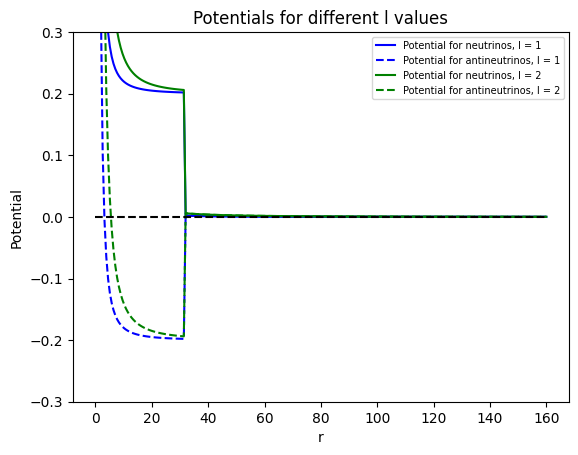

In [467]:
def plot_potentials(N, l_values):
    
    linspace1 = np.linspace(0.001, R, int(.5*N)+1)
    linspace2 = np.linspace(R, distance, int(.5*N))
    r_values = np.unique(np.concatenate((linspace1, linspace2)))
    
    # Create a list of colors for the different l values
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    for i, l in enumerate(l_values):
        # Calculate the potential matrices
        potential_nu = potential_nu_25(N, r_values, l)
        potential_antinu = potential_antinu_25(N, r_values, l)

        # Extract the diagonal values
        V_nu = np.diag(potential_nu)
        V_antinu = np.diag(potential_antinu)

        # Plot the potentials
        plt.plot(r_values, V_nu, color=colors[i], label=f'Potential for neutrinos, l = {l}')
        plt.plot(r_values, V_antinu, color=colors[i], linestyle='dashed', label=f'Potential for antineutrinos, l = {l}')

    plt.xlabel('r')
    plt.ylabel('Potential')
    plt.yscale('linear')
    plt.ylim(-.3, .3)
    plt.title('Potentials for different l values')
    plt.hlines(3.9E-17, xmin=0, xmax=distance, linestyle='dashed', color='black')
    #plt.hlines(-4.9e-16, xmin=0, xmax=distance, linestyle='dashed', color='black')
    
    # Adjust legend size and position
    plt.legend(fontsize=7, loc='upper right')

    plt.savefig('1D_plots/potentials.png')
    plt.show()

# Call the function with a list of l values
plot_potentials(100, [1,2])

In [4]:
# function to graph the nth harmonic
#try solving equation 25 instead


def harmonic(n, N, l):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.001, distance, N)
    E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
    E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
    psi_nu = psi_nu.T
    psi_antinu = psi_antinu.T
    print(f'neutrino energy {n}:', E_pos[n-1])
    print(f'antineutrino energy {n}:', E_neg[n-1])

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first two graphs on the first subplot
    # divide by r_values bc equation 25 defines phi = r*psi
    #Calculate the integral of the absolute square of psi/r over all space
    norm_nu = np.trapz(np.abs(psi_nu[n-1] / r_values)**2, r_values)
    norm_antinu = np.trapz(np.abs(psi_antinu[n-1] / r_values)**2, r_values)

    # Divide psi by the square root of this integral to renormalize
    psi_nu_normalized = psi_nu[n-1] / np.sqrt(norm_nu)
    psi_antinu_normalized = psi_antinu[n-1] / np.sqrt(norm_antinu)


    # Now plot the normalized functions
    ax1.plot(r_values, np.abs(psi_nu_normalized / r_values)**2, color = 'blue', label=f'Potential for neutrinos: n = {n}')
    ax1.plot(r_values, np.abs(psi_antinu_normalized / r_values)**2, color = 'green', label=f'Potential antineutrinos: n = {n}')

    # ax1.plot(r_values, np.abs(psi_pos[n-1] / r_values)**2, color = 'blue', label=f'Potential unchanged: n = {n}')
    # ax1.plot(r_values, np.abs(psi_neg[n-1] / r_values)**2, color = 'green', label=f'Potential negative: n = {n}')


    # Plot the asymmetry on the second subplot
    asym = []
    for i in range(0, len(r_values)):
        if np.abs(psi_nu_normalized[i] / r_values[i])**2 == np.abs(psi_antinu_normalized[i] / r_values[i])**2 and np.abs(psi_nu_normalized[i] / r_values[i])**2 == 0:
            asym.append(0)
        else:
            asym.append((np.abs(psi_nu_normalized[i] / r_values[i])**2 - np.abs(psi_antinu_normalized[i] / r_values[i])**2)/(np.abs(psi_nu_normalized[i] / r_values[i])**2 + np.abs(psi_antinu_normalized[i] / r_values[i])**2))
    ax2.plot(r_values, asym, color='red', label='Asymmetry') # graphing numerically
    
    # graph the potential on the same plot
    #ax1.vlines(3E13, ymin = 0, ymax=.001)
    #ax2.vlines(3E13, ymin = 0, ymax=1)

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'Asymmetry: {N} points, l = {l}')

    # Display legend
    ax1.legend()
    ax2.legend()

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()


# harmonic(1, 1000, l=800000)
# harmonic(1, 2000, l=800000)
# harmonic(1, 3000, l=800000)

In [560]:
def harmonic_many_N(n, N_values, l):
    
    global r_values, psi_antinu, psi_nu
    

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    print("k^2 condition cutoff: ", k_condition)
    for i, N in enumerate(N_values):
        # linspace1 = np.linspace(0.001, R, int(N/2), endpoint=False)
        # linspace2 = np.linspace(R, distance, int(N/2))
        # r_values = np.unique(np.concatenate((linspace1, linspace2)))

        # Calculate the number of points in each segment
        N1 = int(N * R / distance)
        N2 = N - N1
        print(N1, N2)

        # Create linspace from 0.001 to R
        linspace1 = np.linspace(0.001, R, N1, endpoint=False)

        # Create linspace from R to distance
        linspace2 = np.linspace(R, distance, N2)

        # Concatenate the two linspaces to create the piecewise linspace
        r_values = np.linspace(0.001, distance, N)
        r_values = np.concatenate((linspace1, linspace2))
        
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        #print(E_pos)
        # print(E_neg)
        E_pos_within_range = np.count_nonzero((E_pos >= 1E-8) & (E_pos <= 1E-6))

        print(f'neutrino energy {n}:', E_pos[n-1])
        print(f'antineutrino energy {n}:', E_neg[n-1])
        # if E_pos[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for neutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for neutrinos")
        # if E_neg[n-1] < k_condition:
        #     print("Asymmetry condition satisfied for antineutrinos")
        # else:
        #     print("Asymmetry condition not satisfied for antineutrinos")
        psi_nu = (psi_nu.T) / (r_values)
        psi_antinu = (psi_antinu.T) / (r_values)
        psi_nu_normalized = normalize(psi_nu[n-1])
        psi_antinu_normalized = normalize(psi_antinu[n-1])


        print("probability: ", np.sum(np.abs(psi_nu_normalized)**2))
        # Now plot the normalized functions
        ax1.plot(r_values, np.abs(psi_nu_normalized)**2, label=f'probability for neutrinos: N = {N}')
        ax1.plot(r_values, np.abs(psi_antinu_normalized)**2,  linestyle='dashed', label=f'probability for antineutrinos: N = {N}')

        # Plot the asymmetry on the second subplot, defined as such to prevent dividing by zero
        asym = []
        for j in range(0, len(r_values)):
            if np.abs(psi_nu_normalized[j])**2 == np.abs(psi_antinu_normalized[j])**2 and np.abs(psi_nu_normalized[j])**2 == 0:
                asym.append(0)
            else:
                asym.append((np.abs(psi_nu_normalized[j])**2 - np.abs(psi_antinu_normalized[j])**2)/(np.abs(psi_nu_normalized[j])**2 + np.abs(psi_antinu_normalized[j])**2))
            
        print("first 5 asymmetry values: ", asym[:5], "\n")
        ax2.plot(r_values, asym, label=f'Asymmetry: N = {N}') # graphing numerically

    # Set labels and title for the first subplot
    
    
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')
    # ax1.set_ylim(1E-20, 1E-13)
    #ax1.set_xlim(0, 5)

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    #ax2.set_xlim(1.57E14, distance)
    ax2.set_title(f'Asymmetry for different N values, l = {l}')

    # Display legend
    ax1.legend(fontsize = 7, loc = 'upper right')
    ax2.legend(fontsize = 7, loc = 'upper left')

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()

# Call the function with a list of N values
#harmonic_many_N(1, [3000], 1e6)
#harmonic(1, [500, 1000, 2000, 3000, 4000, 5000], 1e6)
#harmonic(1, [500, 1000, 2000, 3000, 4000, 5000], 1e7)

k^2 condition cutoff:  1.0119288512538815
2 10
15.9995 15.999500000000001
15.999500000000001 14.222222222222221
14.222222222222221 14.222222222222221
14.222222222222221 14.222222222222214
14.222222222222214 14.222222222222229
14.222222222222229 14.222222222222229
14.222222222222229 14.222222222222214
14.222222222222214 14.222222222222214
14.222222222222214 14.222222222222229
14.222222222222229 14.222222222222229





15.9995 15.999500000000001
15.999500000000001 14.222222222222221
14.222222222222221 14.222222222222221
14.222222222222221 14.222222222222214
14.222222222222214 14.222222222222229
14.222222222222229 14.222222222222229
14.222222222222229 14.222222222222214
14.222222222222214 14.222222222222214
14.222222222222214 14.222222222222229
14.222222222222229 14.222222222222229





neutrino energy 1: -0.019101087693904062
antineutrino energy 1: -0.20008002507479947
probability:  1.0
first 5 asymmetry values:  [-0.9999204866340068, -0.9999204866165924, 0.9934734289672223, 0.9999992717

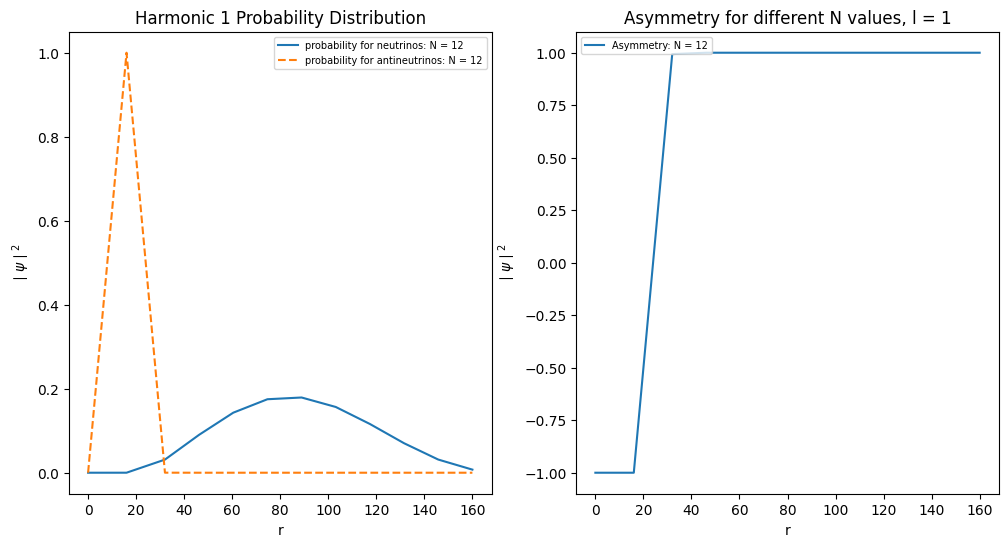

In [561]:
harmonic_many_N(1, [12], 1)
# basically any time the asymmetry condition is not satisfied, there's no asymmetry, which is good
# if the condition is satisfied, there's sometimes asymmetry - inconclusive and runs into numerical issues sometimes
# with the asymmetry changing based on the number of points

k^2 condition cutoff:  1.0119288512538815
[-1.99992024e+01 -1.99975088e+01 -1.99947980e+01 -1.99910353e+01
 -1.99862105e+01 -1.99803209e+01 -1.99733665e+01 -1.99653485e+01
 -1.99562691e+01 -1.99461311e+01 -1.99349382e+01 -1.99226953e+01
 -1.99094085e+01 -1.98950865e+01 -1.98797411e+01 -1.98633904e+01
 -1.98460644e+01 -1.98278222e+01 -1.98088240e+01 -1.97900568e+01
 -1.97804056e+01 -1.97669709e+01 -1.97502971e+01 -1.97382095e+01
 -1.97199605e+01 -1.97009478e+01 -1.96851239e+01 -1.96659313e+01
 -1.96440511e+01 -1.96237807e+01 -1.96041173e+01 -1.95811088e+01
 -1.95567427e+01 -1.95336848e+01 -1.95106677e+01 -1.94849493e+01
 -1.94578688e+01 -1.94315640e+01 -1.94055763e+01 -1.93775079e+01
 -1.93477224e+01 -1.93180665e+01 -1.92890274e+01 -1.92587554e+01
 -1.92265117e+01 -1.91936294e+01 -1.91612697e+01 -1.91286328e+01
 -1.90942445e+01 -1.90584960e+01 -1.90227098e+01 -1.89872305e+01
 -1.89507893e+01 -1.89126632e+01 -1.88737066e+01 -1.88349410e+01
 -1.87960868e+01 -1.87559317e+01 -1.87143374e+01

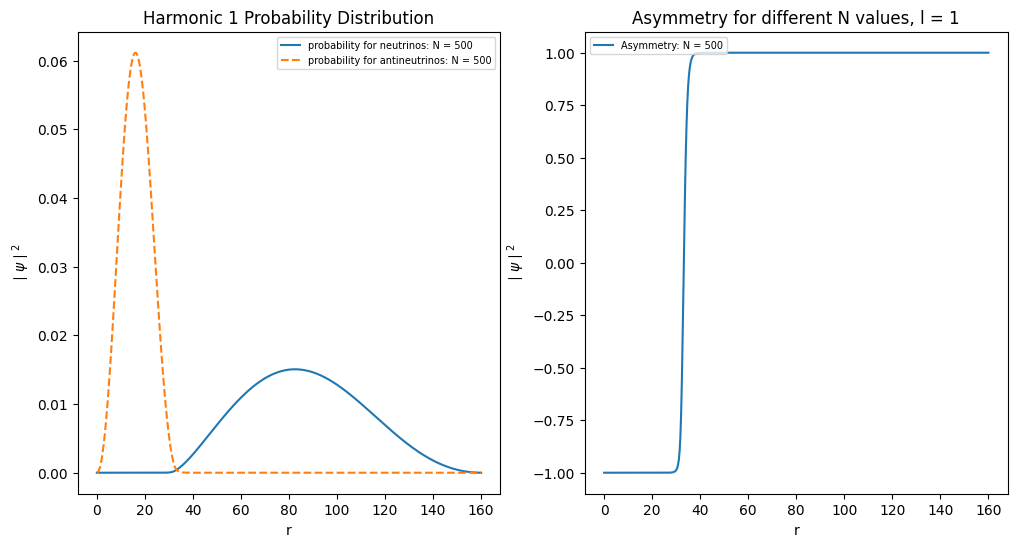

In [8]:
harmonic_many_N(1, [500], 1)

k^2 condition cutoff:  1.0119288512538815
[-3.89060511e+01 -3.89042303e+01 -3.89013073e+01 -3.88972474e+01
 -3.88920407e+01 -3.88856849e+01 -3.88781801e+01 -3.88695282e+01
 -3.88597316e+01 -3.88487940e+01 -3.88367201e+01 -3.88235159e+01
 -3.88091899e+01 -3.87937534e+01 -3.87772234e+01 -3.87596275e+01
 -3.87410168e+01 -3.87215151e+01 -3.87016715e+01 -3.86880823e+01
 -3.86775270e+01 -3.86590147e+01 -3.86457738e+01 -3.86287609e+01
 -3.86081340e+01 -3.85905234e+01 -3.85720847e+01 -3.85494593e+01
 -3.85269910e+01 -3.85064380e+01 -3.84835216e+01 -3.84578994e+01
 -3.84326122e+01 -3.84085022e+01 -3.83824798e+01 -3.83540543e+01
 -3.83254662e+01 -3.82978269e+01 -3.82691112e+01 -3.82380583e+01
 -3.82061454e+01 -3.81748567e+01 -3.81433939e+01 -3.81099660e+01
 -3.80749977e+01 -3.80400156e+01 -3.80054093e+01 -3.79696934e+01
 -3.79321065e+01 -3.78936754e+01 -3.78555090e+01 -3.78171791e+01
 -3.77773327e+01 -3.77359636e+01 -3.76941982e+01 -3.76526553e+01
 -3.76104857e+01 -3.75667194e+01 -3.75217753e+01

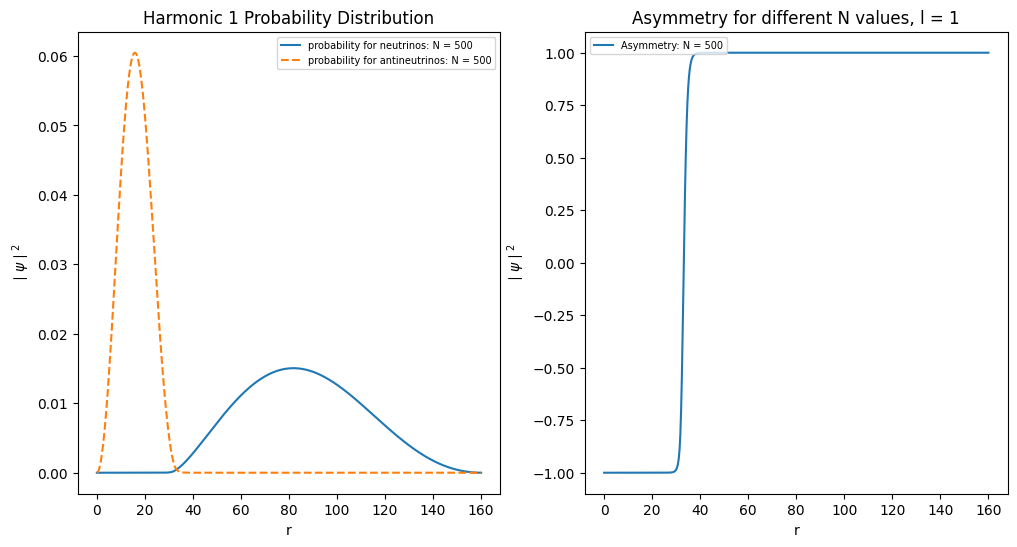

In [17]:
harmonic_many_N(1, [500], 1)
# for the real physical constants, everything gets pushed to the end around l = 1E7
# this would be when our simulation starts to break down
# this is independent of how wide we make the grid (holding the radius of the earth constant)

1.0 l values remaining
neutrino energy 1: -1.530601180288662
antineutrino energy 1: -1.7139129024710347
Asymmetry condition satisfied for neutrinos
Asymmetry condition satisfied for antineutrinos
eigenvalues in the range:  []
indices of the eigenvalues:  []
l values of the eigenvalues:  []
0.9999999999999998
1.0000000000000002


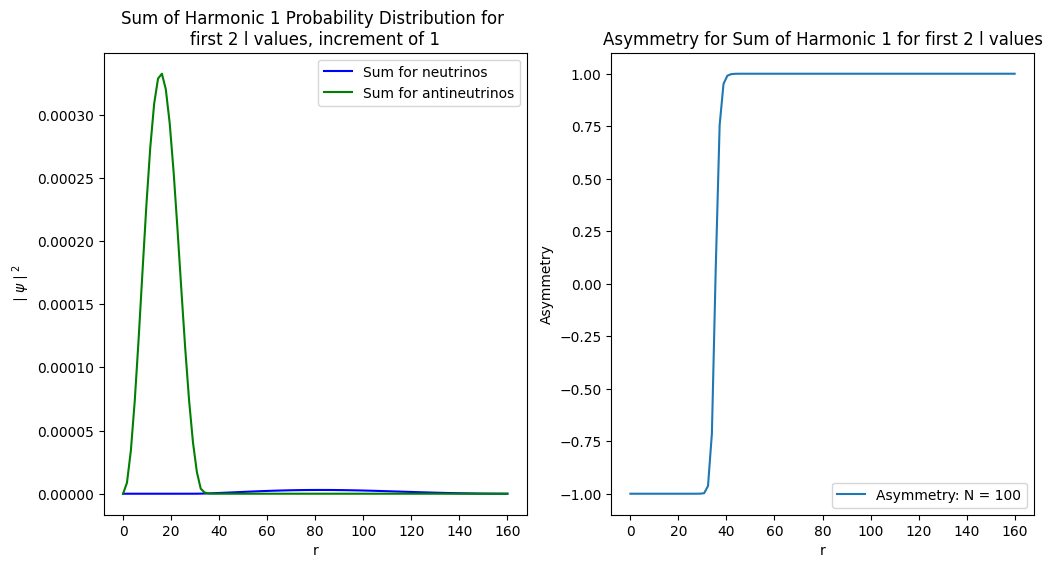

[-0.9999999999994152,
 -0.9999999999994155,
 -0.9999999999992357,
 -0.9999999999987645,
 -0.9999999999976301,
 -0.9999999999947706,
 -0.999999999987051,
 -0.9999999999646862,
 -0.9999999998953861,
 -0.9999999996666271,
 -0.9999999988646482,
 -0.9999999958837499,
 -0.9999999841370409,
 -0.9999999349637199,
 -0.9999997152877088,
 -0.9999986591694578,
 -0.9999931153273655,
 -0.9999605152646445,
 -0.9997349149718939,
 -0.9976822807709618,
 -0.9632182426562858,
 -0.7140069658253617,
 0.07784305300541895,
 0.7556088278543421,
 0.9519799118699204,
 0.9908363625184957,
 0.9982053655886444,
 0.999638096672623,
 0.9999251660805335,
 0.999984199839841,
 0.9999966050887811,
 0.9999992595779926,
 0.9999998364151337,
 0.9999999634462904,
 0.9999999917492843,
 0.9999999981207981,
 0.9999999995684754,
 0.999999999900166,
 0.9999999999767442,
 0.9999999999945481,
 0.9999999999987141,
 0.9999999999996952,
 0.9999999999999273,
 0.9999999999999826,
 0.9999999999999958,
 0.9999999999999991,
 0.999999999999

In [45]:
def harmonic_sum(n, N, l_max, increment):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(0.001, distance, N)
    filtered_eigenvalues = []
    eigenvalue_indices = []
    L_values = []

    # Initialize sum arrays
    sum_psi_nu = np.zeros_like(r_values)
    sum_psi_antinu = np.zeros_like(r_values)

    for l in range(1, l_max, increment):  # loop over l values in a given increment
        print(f'{(l_max - l)/increment} l values remaining')
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        E_neg, psi_antinu = np.linalg.eigh(Hamiltonian_antinu_25(N, r_values, l))
        
        print(f'neutrino energy {n}:', E_pos[n-1])
        print(f'antineutrino energy {n}:', E_neg[n-1])
        if E_pos[n-1] < k_condition:
            print("Asymmetry condition satisfied for neutrinos")
        else:
            print("Asymmetry condition not satisfied for neutrinos")
        if E_neg[n-1] < k_condition:
            print("Asymmetry condition satisfied for antineutrinos")
        else:
            print("Asymmetry condition not satisfied for antineutrinos")
        
        psi_nu = psi_nu.T
        psi_antinu = psi_antinu.T

        # # Add the normalized wavefunctions to the sum
        sum_psi_nu += psi_nu[n-1]
        sum_psi_antinu += psi_antinu[n-1]
        # Filter the eigenvalues
        for i, E in enumerate(E_pos):
            if 1e-10 < abs(E) < 1e-6:
                filtered_eigenvalues.append(E)
                eigenvalue_indices.append(i)
                L_values.append(l)

    # Print the filtered eigenvalues
    print("eigenvalues in the range: ", filtered_eigenvalues)
    print("indices of the eigenvalues: ", eigenvalue_indices)
    print("l values of the eigenvalues: ", L_values)
        

    sum_psi_nu_normalized = normalize(sum_psi_nu)
    sum_psi_antinu_normalized = normalize(sum_psi_antinu)

    print(np.sum(np.abs(sum_psi_antinu_normalized)**2))
    print(np.sum(np.abs(sum_psi_nu_normalized)**2))
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the sum of the normalized wavefunctions
    ax1.plot(r_values, np.abs(sum_psi_nu_normalized / r_values)**2, color = 'blue', label='Sum for neutrinos')
    ax1.plot(r_values, np.abs(sum_psi_antinu_normalized / r_values)**2, color = 'green', label='Sum for antineutrinos')

    # Plot the asymmetry
    asym = []
    for j in range(0, len(r_values)):
        if np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2 and np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 == 0:
            asym.append(0)
        else:
            asym.append((np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 - np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2)/(np.abs(sum_psi_nu_normalized[j] / r_values[j])**2 + np.abs(sum_psi_antinu_normalized[j] / r_values[j])**2))
    ax2.plot(r_values, asym, label=f'Asymmetry: N = {N}') # graphing numerically
    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Sum of Harmonic {n} Probability Distribution for \nfirst {l_max} l values, increment of {increment}')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel('Asymmetry')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'Asymmetry for Sum of Harmonic {n} for first {l_max} l values')

    # Display legend
    ax1.legend()
    ax2.legend()

    plt.savefig('1D_plots/sum_function.png')
    plt.show()

    return asym

# Call the function
harmonic_sum(1, 100, 2, 1)
#harmonic_sum(1, 1000, 100, 1)
#harmonic_sum(1, 1500, 100, 1)

In [260]:
def accurate_eigenvalues(N, l_max, increment, sum_psi_nu=None):
    r_values = np.linspace(0.001, distance, N)
    if sum_psi_nu is None:
        sum_psi_nu = np.zeros_like(r_values)

    for l in range(0, l_max, increment):
        E_pos, psi_nu = np.linalg.eigh(Hamiltonian_nu_25(N, r_values, l))
        psi_nu = psi_nu.T
        for i, E in enumerate(E_pos):
            if 1e-9 < abs(E) < 1e-7:
                # if there's naturally an eigenvalue in the range, add its psi to the graph
                sum_psi_nu += psi_nu[i]
            else:
                print('recursion')
                sum_psi_nu = accurate_eigenvalues(N*10, l_max, increment, sum_psi_nu)


    return sum_psi_nu

accurate_eigenvalues(500, 100, 1)

recursion


KeyboardInterrupt: 

In [13]:
# define the potentials, treating it for now as a 1D step function


def potential_nu(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        
        # inside the earth:
        # it's plus delta because -mU = + delta/k^2
        V_eff_in = kprime_nu**2 + 2 * delta * kprime_nu**2 - (l * (l + 1))/(r[i]**2)

        # outside the earth:
        V_eff_out = k**2 * (1  - (l * (l + 1))/(k**2 * r[i]**2))


        # if i < 3:
        #     H[i,i] = 1E20        
        # el
        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in
            #print("V_eff_in: ", V_eff_in)
        else:
            H[i,i] = V_eff_out
            #print("V_eff_out: ", V_eff_out)
    #print("nu: \n",H)

    return H



def potential_antinu(N, r, l):

    H = np.zeros((N,N))
    for i in range(0, H.shape[0]):
        #try just a step function
        global V_eff_in_neg, V_eff_out_neg
        # inside the earth:
        V_eff_in_neg = kprime_antinu**2 - 2 * delta  * kprime_antinu**2 - (l * (l + 1))/(r[i]**2)

        # outside the earth:
        V_eff_out_neg = k**2 * (1  - (l * (l + 1))/(k**2 * r[i]**2))

        # if i < 3:
        #     H[i,i] = 1E20
        # el
        if i < int(earth_cutoff * N):
            H[i,i] = V_eff_in_neg
            #print("V_eff_in_neg: ", V_eff_in_neg)
        else:
            H[i,i] = V_eff_out_neg
            #print("V_eff_out_neg: ", V_eff_out_neg)
    #print("antinu: \n",H)
    return H

potential_nu(1000, np.linspace(.01, distance, 1000), 10)
potential_antinu(1000, np.linspace(.01, distance, 1000), 1E10)

NameError: name 'kprime_nu' is not defined

In [ ]:
# create the equation to be solved
def Hamiltonian_nu(N, r, l):
    H = second_deriv(N, distance) +  (2/r) * first_deriv(N, distance) + potential_nu(N,r, l)
    return H

def Hamiltonian_antinu(N, r, l):
    H = second_deriv(N, distance) + (2/r) *  first_deriv(N, distance) + potential_antinu(N,r, l)
    return H


-1099999.99999999
-1099999.99999999
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.

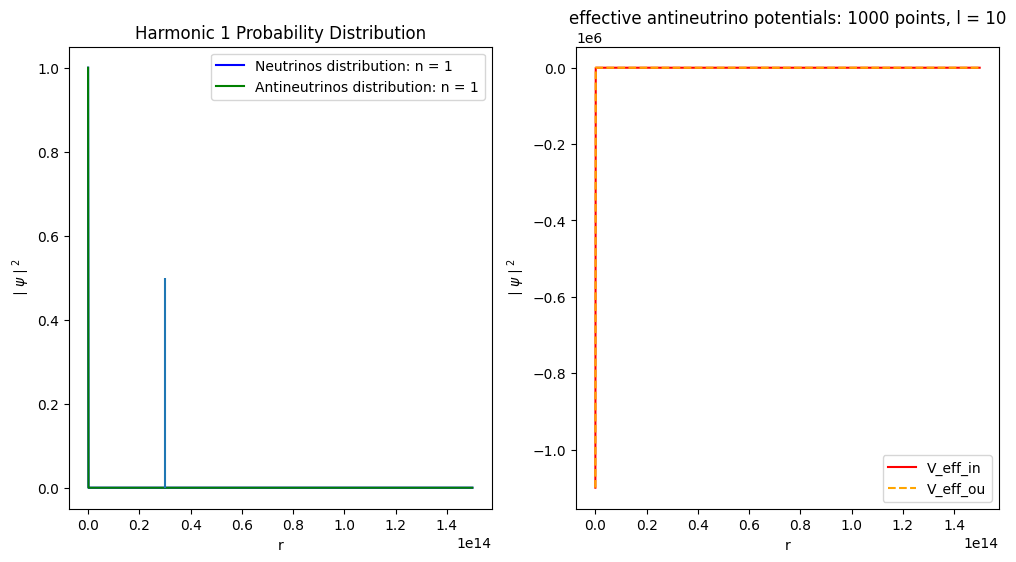

In [ ]:
# function to graph the nth harmonic
#try solving equation 25 instead
# IGNORE THIS CHUNK FOR NOW - THIS IS THE EQUATION 11 STUFF WHICH ISN'T WORKING PROPERLY. THE EQUATION 25 STUFF BELOW IS (KINDA) WORKING

# fix my 2mU to delta definition - it's wrong (tried fixing it make sure its right)

def harmonic(n, N, l):
    
    global r_values, psi_antinu, psi_nu
    
    r_values = np.linspace(.01, distance, N)
    #might try using eig instead of eigh because the matrices are no longer symmetric
    E_pos, psi_nu = np.linalg.eig(potential_nu(N, r_values, l))
    E_neg, psi_antinu = np.linalg.eig(potential_antinu(N, r_values, l))
    print(E_pos[0])
    print(E_neg[0])

    psi_nu = psi_nu.T
    psi_antinu = psi_antinu.T
    print(psi_nu[0])

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first two graphs on the first subplot
    ax1.plot(r_values, np.abs(psi_nu[n-1])**2, color = 'blue', label=f'Neutrinos distribution: n = {n}') # graphing numerically
    ax1.plot(r_values, np.abs(psi_antinu[n-1])**2, color = 'green', label=f'Antineutrinos distribution: n = {n}') # graphing numerically

    asymmetry = (np.abs(psi_nu[n-1])**2 - np.abs(psi_antinu[n-1])**2)# / (np.abs(psi_nu[n-1])**2 + np.abs(psi_antinu[n-1])**2)
    print("Asymmetry;", asymmetry)
    

    # Plot the asymmetry on the second subplot
    ax2.plot(r_values, kprime_antinu**2 * (1 - 2 * delta - (l * (l + 1))/(kprime_antinu**2 * r_values**2)), color='red', label='V_eff_in') # graphing numerically
    ax2.plot(r_values, k**2 * (1  - (l * (l + 1))/(k**2 * r_values**2)), color='orange', label='V_eff_ou', linestyle = '--') # graphing numerically
    
    # graph the potential on the same plot
    ax1.vlines(3E13, ymin = 0, ymax=.5)
    #ax2.vlines(3E13, ymin = 0, ymax=1)

    # Set labels and title for the first subplot
    ax1.set_xlabel('r')
    ax1.set_ylabel(r'$\mid\psi\mid^2$')
    ax1.set_yscale('linear')
    ax1.set_xscale('linear')
    ax1.set_title(f'Harmonic {n} Probability Distribution')

    # Set labels and title for the second subplot
    ax2.set_xlabel('r')
    ax2.set_ylabel(r'$\mid\psi\mid^2$')
    ax2.set_yscale('linear')
    ax2.set_xscale('linear')
    ax2.set_title(f'effective antineutrino potentials: {N} points, l = {l}')

    # Display legend
    ax1.legend()
    ax2.legend()

    # Save the figure
    plt.savefig('1D_plots/step_function.png')

    # Show the plot
    plt.show()



# harmonic(1, 4000, l=1E8)
harmonic(1, 1000, l=10)
# harmonic(1, 4000, l=1E12)
# harmonic(1, 5000, l=1E8)
# harmonic(1, 5000, l=1E10)
# harmonic(1, 5000, l=1E12)
# harmonic(1, 6000, l=1E8)
# harmonic(1, 6000, l=1E10)
# harmonic(1, 6000, l=1E12)